In [0]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
), batch_size=512, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
), batch_size=512, shuffle=True)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.ln1 = nn.BatchNorm1d(784) 
        self.input = nn.Linear(784, 1024)  
        self.fc1 = nn.Linear(1024, 1024)  
        self.fc2 = nn.Linear(1024, 1024)  
        self.fc3 = nn.Linear(1024, 1024)  
        self.fc4 = nn.Linear(1024, 1024)  
        self.fc5 = nn.Linear(1024, 1024)  
        self.op = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.softmax(self.op(x))
        return x
    
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight.data)
        nn.init.zeros_(layer.bias.data)

activation = {}
def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()
    return hook

        

In [10]:
net = Net()
net.fc1.register_forward_hook(get_activation('fc1'))
net.fc2.register_forward_hook(get_activation('fc2'))
net.fc3.register_forward_hook(get_activation('fc3'))
net.fc4.register_forward_hook(get_activation('fc4'))
net.fc5.register_forward_hook(get_activation('fc5'))
net.apply(init_weights)
print(net)

learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Net(
  (ln1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (op): Linear(in_features=1024, out_features=10, bias=True)
)


In [11]:
# For sgd and adam
epoch_count = 20

for epoch in range(epoch_count):
    running_loss = 0.0
    
    for index, data in enumerate(train_loader):
        inputs, labels = data
        
        # Flatten MNIST images into a 784 long vector
        inputs = inputs.view(inputs.shape[0], -1)

        optimizer.zero_grad() 

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if index % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, index + 1, running_loss / 100))
            running_loss = 0.0

print("Done training")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 1.773
[2,   100] loss: 1.599
[3,   100] loss: 1.509
[4,   100] loss: 1.495
[5,   100] loss: 1.489
[6,   100] loss: 1.485
[7,   100] loss: 1.481
[8,   100] loss: 1.479
[9,   100] loss: 1.476
[10,   100] loss: 1.473
[11,   100] loss: 1.472
[12,   100] loss: 1.471
[13,   100] loss: 1.471
[14,   100] loss: 1.471
[15,   100] loss: 1.469
[16,   100] loss: 1.468
[17,   100] loss: 1.469
[18,   100] loss: 1.469
[19,   100] loss: 1.468
[20,   100] loss: 1.468
Done training


Here, we can see adam optimizer giving accuracy of 97.9%.

I have reached these hyper params after trying out followig combinations

Experiment Notes:

Loss function used = Cross entropy

| Exp No|Optimizer|Epochs|Learning Rate|Batch Size|Accuracy|
|----|----|----|----|----|----|
|1|SGD|8|0.05|128|74.05|
|2|SGD|50|0.05|128|79.85|
|3|SGD|100|0.001|128|11.35|
|4|SGD|10|0.001|128|11.35|
|5|SGD|20|0.001|128|21.07|
|6|SGD|50|0.001|128|84.49|
|7|ADAM|10|0.0001|128|96.23|
|8|ADAM|20|0.0001|128|96.78|
|9|ADAM|10|0.0001|128|97.01|
|10|ADAM|10|0.0001|128|97.24|
|11|ADAM|10|0.0001|128|96.54|
|12|ADAM|20|0.0001|256|97.49|
|13|ADAM|20|0.0001|512|97.94|
|14|ADAM|20|0.0001|512|97.98|

Exp 9 had xavier weight initialiazation

Exp 10 had xavier weight and bias zero initialiazation

Exp 11 had xavier weight and bias one initialiazation

Exp 12 had xavier weight and bias zero initialiazation

Exp 13 had xavier weight and bias zero initialiazation

Exp 14 had xavier weight and bias zero initialiazation

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 97.9 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


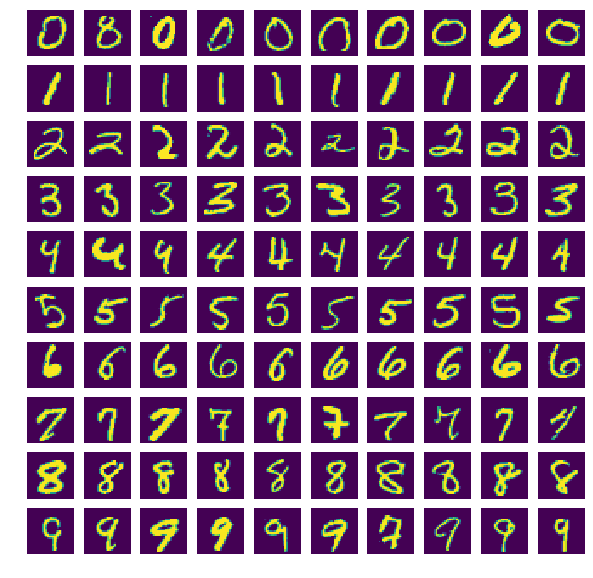

In [13]:
from matplotlib import pyplot as plt

sample_count = 0
sample_required = 1000
thousand_samples = ()
thousand_samples_labels = ()
for batch in test_loader:
    
    images, labels = data
    temp = torch.chunk(images, images.size()[0], 0 )
    temp_labels = torch.chunk(labels, labels.size()[0], 0 )
    if len(thousand_samples)+len(temp)<1000:
        thousand_samples+=temp
        thousand_samples_labels+=temp_labels
    else:
        rem_count = 1000-len(thousand_samples)
        thousand_samples+=temp[:rem_count]
        thousand_samples_labels+=temp_labels[:rem_count]
        break
    
thousand_samples_tensors = torch.cat(thousand_samples, 0)
thousand_labels_tensors = torch.cat(thousand_samples_labels, 0)
del thousand_samples
del thousand_samples_labels


with torch.no_grad():
    images = thousand_samples_tensors.view(thousand_samples_tensors.shape[0], -1)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

fig,axes = plt.subplots(nrows = 10, ncols = 10, figsize=(10,10))

for ax in axes.flatten():
    ax.axis('off')

for num in range(10):
    img_count = 0
    for index, op in enumerate(outputs):
        if torch.max(outputs[index],0)[1].item() == num:
            axes[num, img_count].imshow(thousand_samples_tensors[index][0])
            img_count+=1
        if img_count==10:
            break
fig.show()

In the above plot we can see that our classifier is working correctly.
However, there are still some examples which are miscallified. The reason being those images are activating some neurons for a different class due to the images having high similarity in the stucture of writing strokes.

[873, 790, 393, 924, 114, 16, 148, 100, 914, 673]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


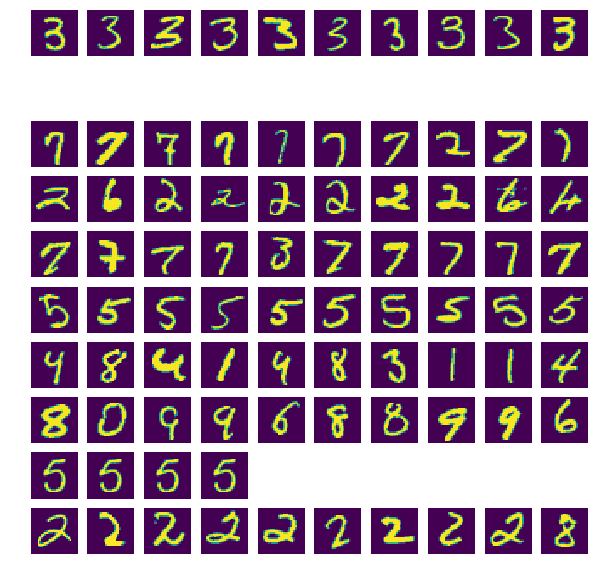

In [14]:
from random import randint
layer_name = 'fc5'

layer_indices = []

for i in range(10):
    p = randint(0,1023)
    if p not in layer_indices:
        layer_indices.append(p)

fig2,axes = plt.subplots(nrows = 10, ncols = 10, figsize=(10,10))

for ax in axes.flatten():
    ax.axis('off')

print(layer_indices)
with torch.no_grad():
    for index in range(10):
        img_count = 0
        for sample in thousand_samples_tensors:
            op = net(sample.view(sample.shape[0], -1))
            op_reduce = torch.tensor([activation[layer_name][0][ind] for ind in layer_indices])
            if torch.max(op_reduce,0)[1].item() == index:
                axes[index, img_count].imshow(sample[0])
                img_count+=1
            if img_count==10:
                break
fig2.show()


In the above plot, we see some rows with some empty images and we some empty rows. This implies the fact that there are some neurons firing only for some specific kind of images and some neurons that do not fire at all.

The neurons which are not firing at all are the ones with empty rows.

The neurons which have some empty images are the ones which fire for images with certain structure.

Here we see images with combination of different classes which have similar structure and hence are being grouped together.


In my opinion, this is the ideal case where we see grouping of images which have some distinctive common features
Some neurons which have half empty images are generating negative outputs and hence are clammped to zero by usage of relu.
The empty row are the neurons which have been deactivated as they are not being productive in classification task.

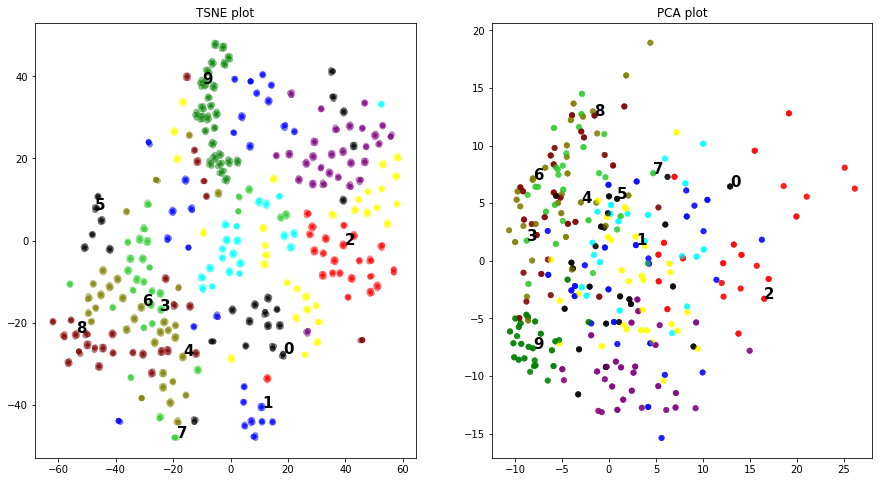

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def get_mean(data):
    class_mean = [torch.tensor([0.0,0.0]) for i in range(10)]
    class_count = [0 for i in range(10)]
    for sample in thousand_labels_tensors:
        class_mean[sample.item()]+=torch.tensor(
            data[sample.item()]
        )
        class_count[sample.item()]+=1
    for index in range(len(class_mean)):
        class_mean[index] = class_mean[index]/class_count[index]
    
    return class_mean



tsne_model = TSNE(n_components=2, random_state=0)
tsne_data = tsne_model.fit_transform(
    thousand_samples_tensors.view(thousand_samples_tensors.shape[0], -1)
)

from matplotlib.colors import ListedColormap

colormap = [
    'red', 'green', 'blue', 'purple', 'limegreen', 
    'yellow', 'cyan', 'maroon', 'black', 'olive'
]
fig, axes = plt.subplots(ncols=2, figsize=(15,8))

axes[0].scatter(
    tsne_data[:,0], tsne_data[:,1], c=thousand_labels_tensors, 
    alpha=0.5, edgecolor='none', cmap=ListedColormap(colormap), label=colormap) 
axes[0].set_title("TSNE plot")


class_mean = get_mean(tsne_data)

for i in range(10):
    axes[0].text(
        class_mean[i][0],class_mean[i][1], 
        str(i), fontsize=15, weight='bold')
    
pca_model = PCA(2)
pca_data = pca_model.fit_transform(
    thousand_samples_tensors.view(thousand_samples_tensors.shape[0], -1)
)

axes[1].scatter(
    pca_data[:,0], pca_data[:,1], c=thousand_labels_tensors, 
    alpha=0.5, edgecolor='none', cmap=ListedColormap(colormap), label=colormap) 
axes[1].set_title("PCA plot")

class_mean = get_mean(pca_data.astype('float32'))

for i in range(10):
    axes[1].text(
        class_mean[i][0],class_mean[i][1],
        str(i), fontsize=15, weight='bold'
    )

plt.show()


Though there is some grouping in the class plots, we see that these groups are not distinctive. 

Looking at the above plots, we see that the images are not easy to be classified.

If the classification task was easy we would have found better grouping done by tSNE as it maintains local class distance even after the dimentionality reduction. From the plots it is visible that the distances between different classes not much.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


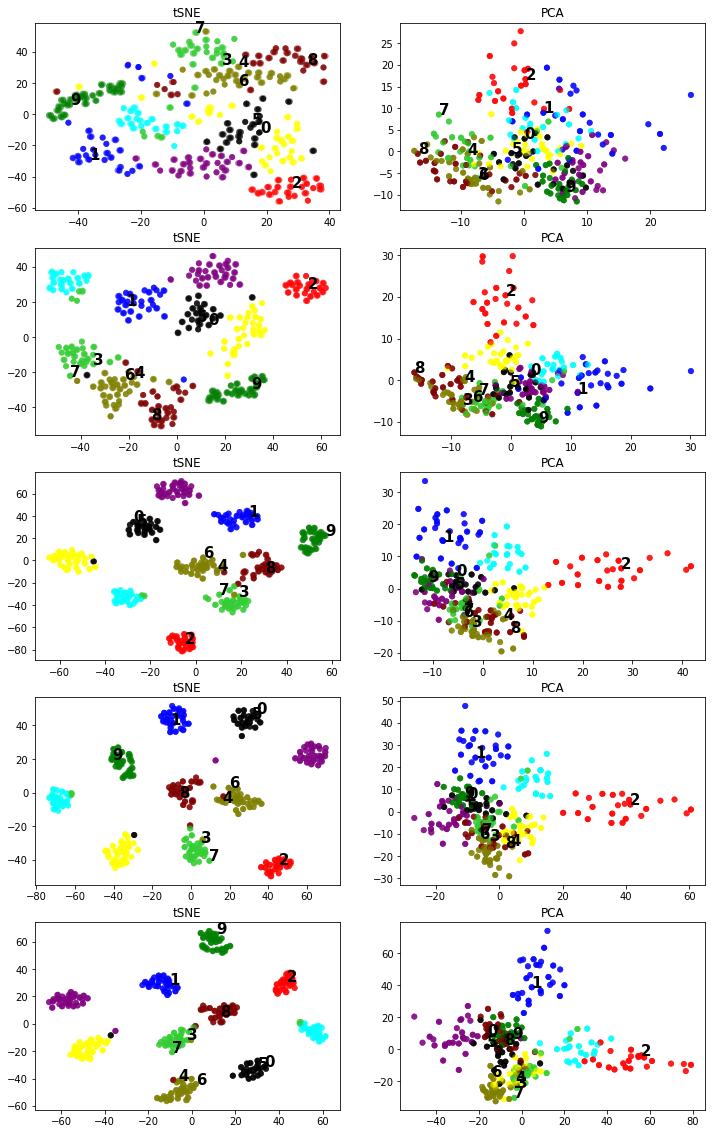

In [16]:
layer_wise_activations_data = {
    'fc1':[],
    'fc2':[],
    'fc3':[],
    'fc4':[],
    'fc5':[],
}
layers = ['fc'+str(layer) for layer in range(1,6) ]
with torch.no_grad():
    for sample in thousand_samples_tensors:
        net(sample.view(sample.shape[0], -1))
        for layer in layers:
            layer_wise_activations_data[layer].append(activation[layer][0])

fig,axes = plt.subplots(nrows = 5, ncols = 2, figsize=(12,20))


for index, layer in enumerate(layers):
    tsne_model = TSNE(n_components=2, random_state=0)
    tsne_data = tsne_model.fit_transform(torch.stack(layer_wise_activations_data[layer]))

    axes[index,0].scatter(
        tsne_data[:,0], tsne_data[:,1], c=thousand_labels_tensors, 
        alpha=0.5, edgecolor='none', cmap=ListedColormap(colormap)
    )
    axes[index,0].set_title('tSNE')

    class_mean = get_mean(tsne_data)
    for i in range(10):
        axes[index, 0].text(
            class_mean[i][0],class_mean[i][1],
            str(i), fontsize=15, weight='bold'
        )


    pca_model = PCA(2)
    pca_data = pca_model.fit_transform(torch.stack(layer_wise_activations_data[layer]))

    axes[index,1].scatter(
        pca_data[:,0], pca_data[:,1], c=thousand_labels_tensors, 
        alpha=0.5, edgecolor='none', cmap=ListedColormap(colormap)
    )
    axes[index,1].set_title('PCA')
    
    class_mean = get_mean(pca_data.astype('float32'))
    for i in range(10):
        axes[index, 1].text(
            class_mean[i][0],class_mean[i][1],
            str(i), fontsize=15, weight='bold'
        )






Here we can conclude following facts
1. As the network gets deeper, the layers extract better and better features.
2. In the first two layer we see the plots are not well segregated. However, in the 3,4,5 layers we see that the classes are grouped well meaning the activations have learned good features which are being used to classify the layers. 



We also see that tSNE is outperforming PCA when it comes to grouping and maintaining the distance between the classes. 

The reasong for this is the fact that PCA does not maintain the local distance when the dimentions are reduced but tSNE does. Hence the tSNE plots have well separated classes but in PCA the classes are close to each other. 